We will see below different ways to preprocess image data

1. Keras preprocessing utilities and layers to read a directory of images on disk
2. Creating input pipeline from using tf.data
3. Downloading a dataset from TensorFlow Datasets


In [28]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Exploring dataset

The flowers dataset contains 5 sub-directories, one per class. Folder struture is shown below.


flowers_photos/

      daisy/
  
      dandelion/
  
      roses/
  
      sunflowers/
  
      tulips/
  

In [5]:
dataset_url =  "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                        fname='flower_photos',
                        untar=True
                       )
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

os.listdir(data_dir)

228818944/228813984 [==============================] - 35s 0us/step


## View Sample images

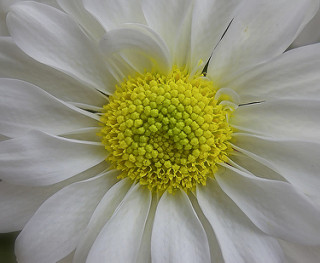

In [20]:

daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(daisy[0])

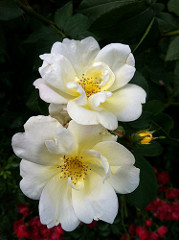

In [22]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(roses[0])

## 1. Keras processing utilities

load these images off disk using tf.keras.preprocessing.image_dataset_from_directory.

In [25]:
batch_size = 32
img_height = 180
img_width = 180


train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                    batch_size=batch_size,
                                                    image_size=(img_height, img_width),
                                                    seed= 123,
                                                    validation_split=0.2,
                                                    subset="training")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                    batch_size=batch_size,
                                                    image_size=(img_height, img_width),
                                                    seed= 123,
                                                    validation_split=0.2,
                                                    subset="validation")

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [27]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Visualise the classes

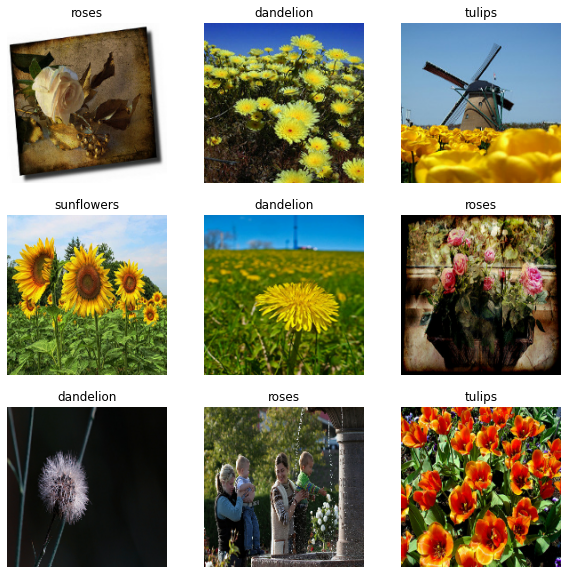

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [30]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are the corresponding labels to the 32 images.

## Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.Rescaling layer.

There are two ways to use this layer. 
1. You can apply it to the dataset by calling map.
2. you can include the layer inside your model definition to simplify deployment.

In [32]:
#1. calling map.

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99638706


## Train a model

In [34]:
#2.  include the layer inside your model definition to simplify deployment.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [35]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 25s 255ms/step - loss: 1.2425 - accuracy: 0.4680 - val_loss: 1.1847 - val_accuracy: 0.5272
Epoch 2/3
92/92 [==============================] - 21s 229ms/step - loss: 1.0298 - accuracy: 0.5841 - val_loss: 1.0014 - val_accuracy: 0.6063
Epoch 3/3
92/92 [==============================] - 21s 234ms/step - loss: 0.8568 - accuracy: 0.6642 - val_loss: 0.9499 - val_accuracy: 0.6458


## 2. Using tf.data for finer control
The above tf.keras.preprocessing utilities are a convenient way to create a tf.data.Dataset from a directory of images. For finer grain control, you can write your own input pipeline using tf.data.

In [43]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [38]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\Seema\\.keras\\datasets\\flower_photos\\roses\\4503599544_3822e7d1be.jpg'
b'C:\\Users\\Seema\\.keras\\datasets\\flower_photos\\daisy\\2573240560_ff7ffdd449.jpg'
b'C:\\Users\\Seema\\.keras\\datasets\\flower_photos\\dandelion\\2620243133_e801981efe_n.jpg'
b'C:\\Users\\Seema\\.keras\\datasets\\flower_photos\\daisy\\10993818044_4c19b86c82.jpg'
b'C:\\Users\\Seema\\.keras\\datasets\\flower_photos\\daisy\\11124324295_503f3a0804.jpg'


In [47]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
2936
734


In [48]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [56]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [57]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


### Configure dataset for performance
To train a model with this dataset you will want the data:

To be well shuffled.
To be batched.
Batches to be available as soon as possible.
These features can be added using the tf.data API. For more details, see the Input Pipeline Performance guide.

In [58]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

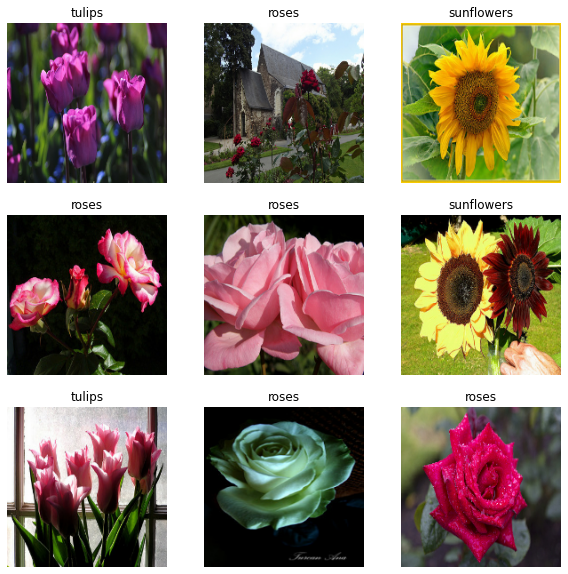

In [59]:
#Visualize the data

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [60]:
# We have built a similar tf.data.Dataset to the one created by the keras.preprocessing above.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 25s 259ms/step - loss: 0.7422 - accuracy: 0.7190 - val_loss: 0.8307 - val_accuracy: 0.6880
Epoch 2/3
92/92 [==============================] - 21s 229ms/step - loss: 0.5783 - accuracy: 0.7916 - val_loss: 0.7720 - val_accuracy: 0.7125
Epoch 3/3
92/92 [==============================] - 21s 232ms/step - loss: 0.4063 - accuracy: 0.8542 - val_loss: 0.8392 - val_accuracy: 0.6975


## Using TensorFlow Datasets
Till now we focused on loading data off disk. We can also find a dataset to use by exploring the large catalog of easy-to-download datasets at TensorFlow Datasets. 

In [61]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to C:\Users\Seema\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [62]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


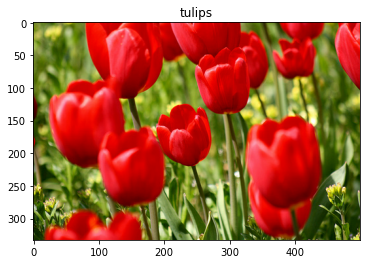

In [63]:
#Retrieve an image from the dataset.
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [70]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [ ]:
## Fore more details -  tf.data: Build TensorFlow input pipelines guide
https://www.tensorflow.org/guide/data
    